In [1]:

# Importing relevant packages
import cv2
import numpy as np
import pims
import trackpy as tp
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from copy import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#%matplotlib tk # uncomment dit als je interactieve plots wilt hebben (je moet de kernel restarten als je dit weer uit wilt zetten)

## Loading in video
In the cell below you can put the name of the video you want to be analysed. Make sure you put the video in the same folder as where the file with this code is put.

In [4]:
fileName = r'.\Tracking_videos\23-4-2025\20250423_105142.mp4'

In [5]:
video = pims.Video(fileName) # Loading in video and converting them to individual frames
duration = video.duration # Duration of video in seconds
frameRate = video.frame_rate # Framerate of video

print(f'duration:{round(duration,3)}, framerate: {round(frameRate,3)}, # of frames: {round(duration * frameRate)}')

duration:81.666, framerate: 30.0, # of frames: 2450


Use the snippet of code underneath if you want to only analyse a selection of frames. When working with large videos it is advisable to first test your code on a small selection of frames. This way you can quickly see if everything works as expected!

In [6]:
startframe = 180
endframe = len(video)
frames = video[startframe:endframe]
print('Amount of frames:', len(frames))

Amount of frames: 2270


In [7]:
def boatCentre(frames):
    """
    Args:
        frames to be analysed

    Returns:
       positions [np.array]: list of frames with only the positions of the tracking dots highlited.
       blurs [np.array]: list of frames with the results of the blurring and clipping shown.
       newset [np.array]: list of original frames with the tracked dots highlited with circles.
       circstore [list]: list with lists of tuples containing the information (pos & radius) of each circle per frame.
       indecesused [list]: list of the indeces corresponding to the frames that were processed from the frames input.
    """
    circstore = [] # list of lists with tuples containing the info of the circles per frame
    shorten = 1 #10
    reducefps = 10
    colorthreshold = 0.35 # threshold value for when to count the pixel as a tracking cap 0 means everything counts
    positions, blurs, newset = [], [], [] #lists to be filled with their respective frame types
    indecesused = []

    for i in range(0,int(len(frames)/shorten),reducefps):
        indecesused.append(i)
        cimg= copy(frames[i]) # makes a copy of the original frame as to not edit over the original

        r,gr,b = cv2.split(frames[i]) # split the color image into different channels    
        blurthis = (abs((r/255)-(gr/255))+abs((gr/255)-(b/255))+abs((r/255)-(b/255))) # calculate the color difference for each pixel from 0-1 (this highlights pixels with a lot of a single color)

        blurthis[blurthis>=colorthreshold] = 255 # set color difference values above a threshold to max intensity
        blurthis[blurthis<colorthreshold] = 0 # set color difference values below the same threshold to zero intenisty
        blur = cv2.medianBlur(np.uint8(blurthis), ksize=9) # blur to help houghcircles. If all went well, only the colored dots on the cheerioboat remain.

        circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.5, minDist=35, param1=60, param2=10, minRadius=4, maxRadius=20) # actually find the circles in the edited image  #60,10
        circles = np.uint16(np.around(circles)) # round the found circle positions and radii
        
        circstore.append(circles) # save the positions and radii of the circles
        # blur = cv2.cvtColor(blur,cv2.COLOR_GRAY2RGB)

        background = np.zeros_like(blur, np.uint8) # create a black greyscale background 
    
        for j in circles[0,:]:
            # draw the centers of the circles
            cv2.circle(background,(j[0],j[1]),3,(255,0,0),-1) 
            cv2.circle(blur,(j[0],j[1]),3,255, -1) 
            cv2.circle(cimg,(j[0],j[1]),3,(255,0,0),-1) 
            
            # draw the edge of the circles
            # cv2.circle(background,(i[0],i[1]),i[2],(0,255,0),1)
            cv2.circle(blur,(j[0],j[1]),j[2],(0,255,0),1)
            cv2.circle(cimg,(j[0],j[1]),j[2],(0,255,0),1)
        
        positions.append(background)
        blurs.append(blur)
        newset.append(cimg)

        print('finished frame:', i)
    
    return np.array(positions), np.array(blurs), np.array(newset), circstore, indecesused

## Editing all frames

In [8]:
positions, _, newset, _, indecesused,= boatCentre(frames) # returns frames with dots placed in the centre of mass of the boats for all frames

# print('aantal cirkels:', int(len(np.ndarray.flatten(np.array(circstore)))/3))

finished frame: 0
finished frame: 10
finished frame: 20
finished frame: 30
finished frame: 40
finished frame: 50
finished frame: 60
finished frame: 70
finished frame: 80
finished frame: 90
finished frame: 100
finished frame: 110
finished frame: 120
finished frame: 130
finished frame: 140
finished frame: 150
finished frame: 160
finished frame: 170
finished frame: 180
finished frame: 190
finished frame: 200
finished frame: 210
finished frame: 220
finished frame: 230
finished frame: 240
finished frame: 250
finished frame: 260
finished frame: 270
finished frame: 280
finished frame: 290
finished frame: 300
finished frame: 310
finished frame: 320
finished frame: 330
finished frame: 340
finished frame: 350
finished frame: 360
finished frame: 370
finished frame: 380
finished frame: 390
finished frame: 400
finished frame: 410
finished frame: 420
finished frame: 430
finished frame: 440
finished frame: 450
finished frame: 460
finished frame: 470
finished frame: 480
finished frame: 490
finished fr

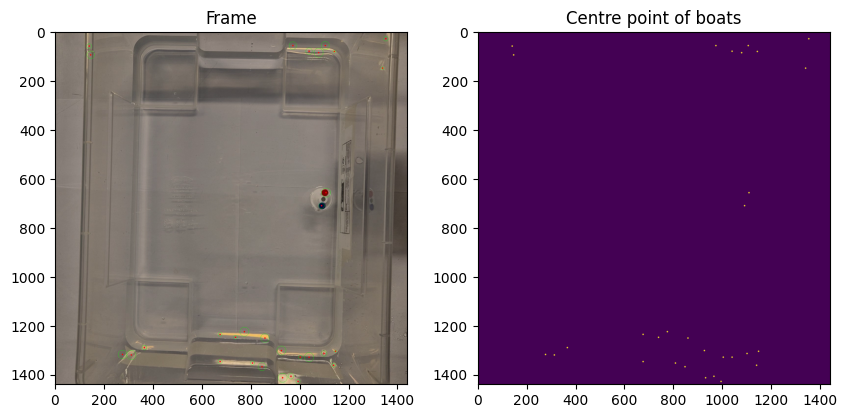

In [9]:

fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[0].imshow(newset[0])
axs[0].set_title('Frame')
axs[1].imshow(positions[0])
axs[1].set_title('Centre point of boats')

plt.show()

The cell below will search for all the dots we put in the frames and save their positions.

In [10]:
f = tp.batch(positions, diameter=5, minmass=20, processes='auto', invert=False)#37

Frame 226: 17 features


We've now got locations for all our dots! But to get information on the movement of the boats it is important that we can label boats. The code snippet below will compare all our dots frame by frame and detect which ones are which boat.

In [11]:
search_range = 140 
memory       = 20

t = tp.link(f, search_range=search_range, memory=memory)# WAS 90
# t = tp.filter_stubs(t,t['frame'].max() * 0.70 )

Frame 102: 22 trajectories present.


KeyboardInterrupt: 

In [13]:
t = t[t['particle'] != t.loc[(t['frame'] == 0) & (t['x'] > 1400)]['particle'].iloc[0]]


NameError: name 't' is not defined

In [88]:
t

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
1,1093.856934,895.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,0,1
0,1052.856934,901.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,0,2
4,1108.856934,884.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,1,1
3,1070.856934,896.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,1,2
6,1087.856934,887.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,2,2
...,...,...,...,...,...,...,...,...,...,...
1784,635.856934,506.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,599,2
1785,676.856934,508.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,599,1
1787,676.856934,509.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,600,1
1789,676.856934,512.856934,398.560505,1.395794,0.217477,49.625454,2805.0,0.0,601,1


In [ ]:
# Het middenpunt van het bootje uitrekenen
x = []
y = []

for framenr in list(set(t['frame'])):
    x.append(0.5 * sum(t.loc[t['frame'] == framenr]['x']))
    y.append(0.5 * sum(t.loc[t['frame'] == framenr]['y']))



In [12]:
theta = []
particles = list(set(t['particle']))
for framenr in list(set(t['frame'])):
    tt = t[t['frame'] == framenr]
    try: # calculate the angle of the particle with respect to an arbitrary axis
        dx = float((tt.loc[tt['particle'] == particles[1], ['x']]).iloc[0]) - float((tt.loc[tt['particle'] == particles[0], ['x']]).iloc[0])
        dy = float((tt.loc[tt['particle'] == particles[1], ['y']]).iloc[0]) - float((tt.loc[tt['particle'] == particles[0], ['y']]).iloc[0])
        theta.append(np.arccos(dx/np.sqrt(np.square(dx) + np.square(dy))))
    except: # if a frame does not have every particle, repeat the previous value
        theta.append(theta[-1])
display(theta)

NameError: name 't' is not defined

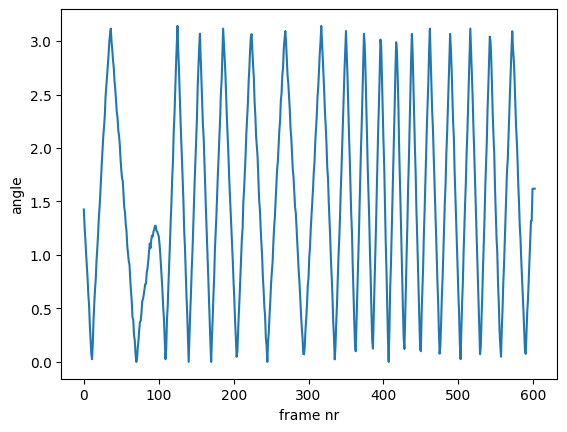

In [101]:

plt.plot(list(set(t['frame'])), theta)
plt.xlabel('frame nr')
plt.ylabel('angle')
plt.show()

## Average speed

In [18]:
displacement = []
averageSpeed = []
for i in list(set(t['particle'])):
    tt = t.loc[t['particle'] == i]
    tt = tt.reset_index()
    S = 0 
    for j in range(1, len(tt['x'])):
        ds = np.sqrt((tt['x'].iloc[j] - tt['x'].iloc[j - 1])**2 + (tt['y'].iloc[j] - tt['y'].iloc[j - 1])**2)
        S = S + ds
    displacement.append(S)
    averageSpeed.append(S/duration)

data = {
    'particle':  list(set(t['particle'])),
    'displacement' : displacement,
    'averageSpeed' : averageSpeed
}
df = pd.DataFrame(data)
display(df)

,particle,displacement,averageSpeed
0,1,5043.117202,76.022919
1,2,7125.163917,107.408918


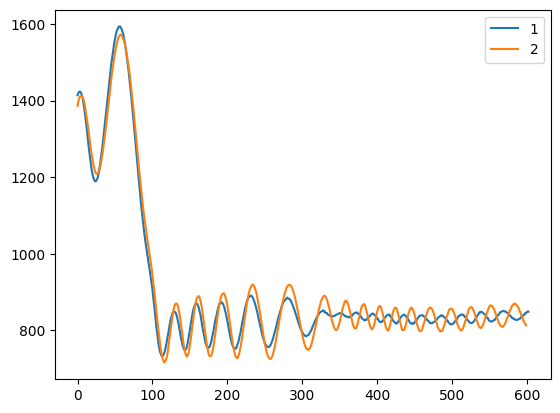

In [17]:
if t['particle'].max() != 0:
    for i in list(set(t['particle'])):
        tt = t.loc[t['particle']==i]
        plt.plot(tt['frame'], np.sqrt(tt['y']**2 + tt['x']**2), label = i)
else:
    plt.plot(tt['frame'], np.sqrt(tt['y']**2 + tt['x']**2), label = 0)
plt.legend()
plt.show()

We've now got the trajectory of our boats! :D

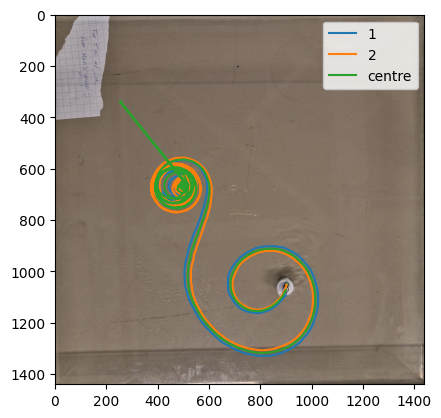

In [103]:
plt.axes().set_aspect('equal')
if t['particle'].max() != 0:
    for i in list(set(t['particle'])):
        tt = t.loc[t['particle']==i]
        plt.plot(tt['x'], tt['y'], label = i)
else:
    tt = t.loc[t['particle']==0]
    plt.scatter(tt['x'], tt['y'], c = tt['frame'], s = 0.7)
    plt.plot(tt['x'], tt['y'], color = 'black', zorder = -10, linewidth = 0.5)

plt.plot(x, y, label='centre')

plt.imshow(frames[0], zorder = -20)
plt.legend()
plt.show()